In [69]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from PIL import Image
from skimage import io, filters, measure
import matplotlib.cm as cm
import tesseract
import pytesseract
from pylab import rcParams
from scipy import ndimage
import imutils
rcParams['figure.figsize'] = 10, 10

sample_dir = os.path.expanduser('~/Dropbox/work/ornaments/samples')

def ish(im, s=8):
    plt.figure(figsize=(s,s))
    io.imshow(im)
    
def load_file(fn):
    return io.imread(fn)

def compute_skew_blank(image, ran=10, n=10):
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    def of(a):
        if a != 0: 
            rotated = ndimage.rotate(opening, a)
        else:
            rotated = opening
        
        #TODO: sole pixels will throw off the findnonzero
        non_zero_pixels = cv2.findNonZero(rotated)
        [x,y,w,h] = cv2.boundingRect(non_zero_pixels)
        
        sums = np.sum(rotated[y:y+h,x:x+w], axis=1)
        Iblank = sums < 10
        nblank = np.count_nonzero(Iblank)
        return nblank, Iblank
    
    angles = np.linspace(-ran, ran, n)
    nblanks = np.array([of(x)[0] for x in angles])
    i = nblanks.argmax()
    
    print zip(angles,nblanks)
    return angles[i], opening
    
def compute_skew(image, ran=5):
    horizontal = 90
    image = cv2.bitwise_not(image)
    height, width = image.shape

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=0.5*width, maxLineGap=40)
    angles = np.array([np.arctan2(x2 - x1, y2 - y1)*180.0/np.pi for x1, y1, x2, y2 in lines[0]])
    angles = (angles + 180) % 360 - 180
    
    I1 = abs(angles) >= (horizontal - ran)
    I2 = abs(angles) <= (horizontal + ran)
    I = np.logical_and(I1,I2)
    am = angles[I].mean()
    
    return am, angles[horizontal] - am, lines[0][I]

def nonzero_outside_margin(img, rect, m=30):
    [x, y, w, h] = rect
    
    height, width = img.shape
    
    # take a slightly larger bounding box in the
    # the reference image. If that margin is empty its an ornament
    xl1 = max(0, x - m)
    xl2 = min(width, x + w + m)

    yl1 = max(0, y - m)
    yl2 = min(height, y + h + m)

    view = np.zeros(img.shape)
    view[yl1:yl2, xl1:xl2] = img[yl1:yl2, xl1:xl2]
    view[y:y+h,x:x+w] = 0
    
    n = np.count_nonzero(view)
    
    return n

Num images loaded 34
<type 'numpy.ndarray'> (2464, 1440) 0 255


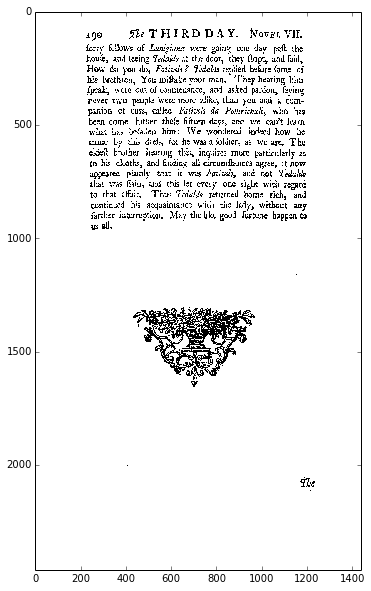

In [52]:
os.chdir(sample_dir)
files = glob.glob("*.png")
imgs = map(load_file, files)
data = zip(files, imgs)

# load templates
templates = map(load_file, ["capital_template_%s.png" %s for s in ["big", "med", "small"]])
# remove channel info
templates = [np.squeeze(x[:,:,0]) for x in templates]
cap_templ_big, cap_templ_med, cap_templ_small = templates

print "Num images loaded", len(imgs)

im = imgs[0]
print type(im),im.shape, im.min(), im.max()
io.imshow(im)

[(-5.0, 173), (-2.5, 209), (0.0, 203), (2.5, 162), (5.0, 174)]
-2.5


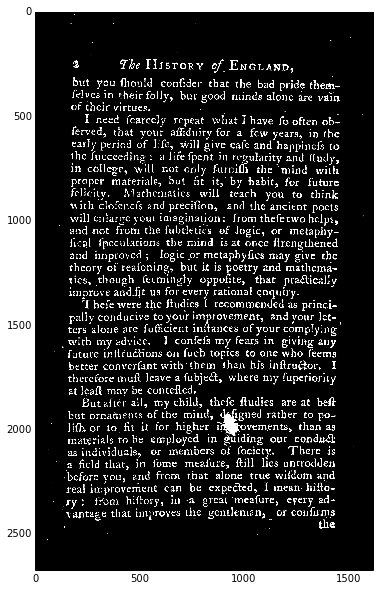

In [3]:
_,thresh = cv2.threshold(imgs[11],150,255,cv2.THRESH_BINARY_INV)
a, resi = compute_skew_blank(thresh, ran=5, n=5)
print a
rotated = ndimage.rotate(thresh, a)
io.imshow(rotated)

In [4]:
def is_ornament(c, width, height):
    # top left bounding rect
    [x,y,w,h] = cv2.boundingRect(c)

    # an ornament does not start past half the page
    if x > 0.5*width:
        return False

    # copy artefact
    if (x + w) < 50 and h > 0.5*height:
        return False

    # capital letter
    # TODO: absolute values
    if x < 0.3*width and (170 <= w <= 210) and (170 <= h <= 210):
        return True

    # wide ornament (title or divider)
    if w > 0.8*width:
        return True

    # small things are bad
    if w*h < 35000:
        return False

    # big things are good
    if w*h > 40000:
        return True

    # if not a capital then an ornament does not end before half the page
    if x+w < 0.5*width:
        return False

    # other than capital letters, ornaments should be horizontally centered
    if abs((x + w/2) - (width/2)) < 100:
        return True

    return False

* 0 000020070002000.png (2464, 1440)
* 1 000020070002190.png (2368, 1248)
* 2 000020070002520.png (2368, 1248)
* 3 130000010300090.png (1971, 1121)
* 4 130000010300110.png (2023, 1138)
* 5 130000150001210.png (2814, 1658)
* 6 130000150001250.png (2813, 1659)
* 7 130000160000080.png (3064, 1848)
* 8 130000160000090.png (3202, 1715)
* 9 130000160000380.png (3062, 1944)
* 10 130000210000050.png (2981, 1764)
* 11 130010010100090.png (2608, 1503)
* 12 130010010200120.png (2569, 1430)
* 13 130010020200010.png (2519, 1486)
* 14 130010030200010.png (2453, 1287)
* 15 130010030300020.png (2343, 1331)
* 16 130010030300030.png (2492, 1331)
* 17 130010040100070.png (2337, 1370)
* 18 130010040100110.png (2337, 1370)
* 19 130010040102190.png (2309, 1359)
* 20 130010040102660.png (2326, 1348)
* 21 130010040103070.png (2309, 1359)


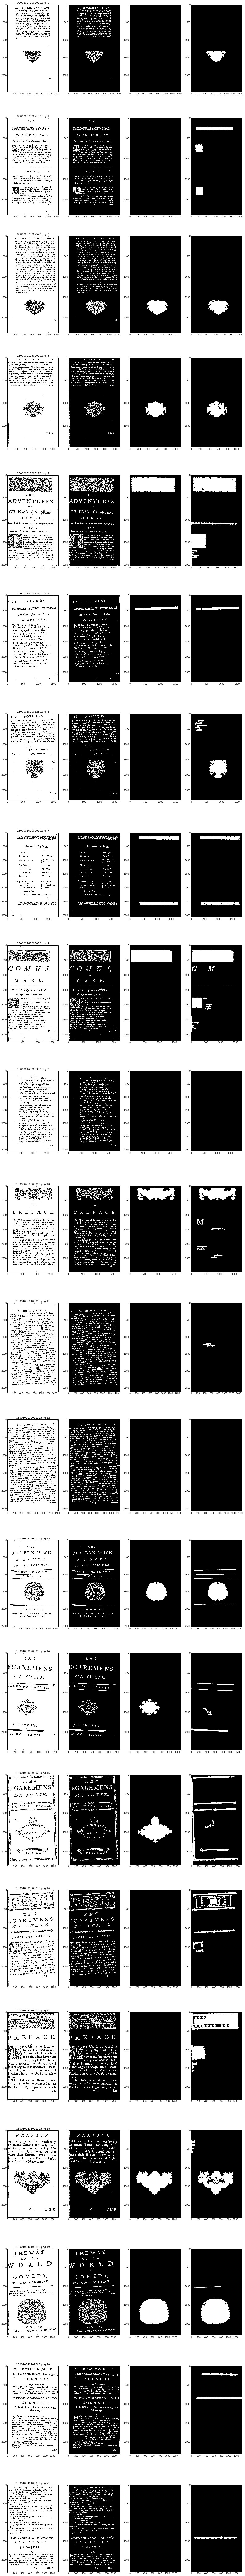

In [7]:
tim = imgs[3].copy()

def proc(imgI):
    fig, ax = plt.subplots(len(imgI),4, squeeze=False)
    fig.set_size_inches(20,10*len(imgI))

    for i,j in enumerate(imgI):
        img = imgs[j]
        
        print "*", j, files[j], img.shape
        if len(img.shape) == 3:
            img = np.squeeze(img[:,:,0])

        height, width = img.shape
        
        def cf_big(c, reference):
            box = cv2.boundingRect(c)
            [x,y,w,h] = box
            height, width = reference.shape
            
            rect_area = w*h
            area = cv2.contourArea(c)
            ratio = area/rect_area
            
            n = nonzero_outside_margin(reference, box, m=30)
            
            # big things are good
            if rect_area > 100000 and n < 100:
                #plt.figure()
                #io.imshow(view)
                #cv2.rectangle(reference,(x,y),(x+w,y+h),(255,255,255),2)
                #cv2.rectangle(reference,(xl,yl),(xl+wl,yl+hl),(255,255,255),2)
                #print "$$"
                #print x,y,w,h
                #print xl,yl,wl,hl
                #print n
                return True
            
            return False
        
        _,thresh = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
        kernel_blank = cv2.getStructuringElement(cv2.MORPH_RECT,(4,1))
        eroded = cv2.erode(thresh, kernel_blank, iterations=1)
        sums = np.sum(eroded, axis=1)
        Iblank = sums < 5
        
        kernel_big = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
        opening_big = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
        dilated_big = cv2.dilate(opening_big, kernel_big, iterations=1)
        closing_big = cv2.morphologyEx(dilated_big, cv2.MORPH_CLOSE, kernel_big)
        closing_big = closing_big.copy()
        closing_big[Iblank,:] = 0
        contours_big, _ = cv2.findContours(closing_big.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        contours_bigf = [x for x in contours_big if cf_big(x, opening)]
        contoured_big = np.zeros(img.shape)
        cv2.drawContours(contoured_big, contours_bigf, -1, (255,255,255), -1)

        dilated = cv2.dilate(opening, kernel, iterations=4)
        closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
        closing[Iblank,:] = 0
        contours, hierarchy = cv2.findContours(closing.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        contoured = np.zeros(closing.shape)
        cv2.drawContours(contoured, contours, -1, (255,255,255), 3)

        def cf(c): return is_ornament(c, width, height)
        big_contours = filter(cf, contours)
        big_contoured = np.zeros(closing.shape)
        cv2.drawContours(big_contoured, big_contours, -1, (255,255,255), -1)

        # draw rectangle around contour on original image
        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),2)
        
        ax[i,0].set_title(files[j] + " " + str(j))
        ax[i,0].imshow(img,cmap=cm.Greys_r)
        ax[i,1].imshow(opening,cmap=cm.Greys_r)
        ax[i,2].imshow(contoured_big,cmap=cm.Greys_r)
        ax[i,3].imshow(big_contoured,cmap=cm.Greys_r)


#proc([8,9,10,11])
#proc([4,8])
proc(range(22))
#proc([1,4,11,12,14,15,16,17])
#proc([6,8])



[[[   1   -1   -1   -1]
  [   2    0   -1   -1]
  [   3    1   -1   -1]
  ..., 
  [4146 4144   -1 2677]
  [4147 4145   -1 2677]
  [  -1 4146   -1 2677]]]


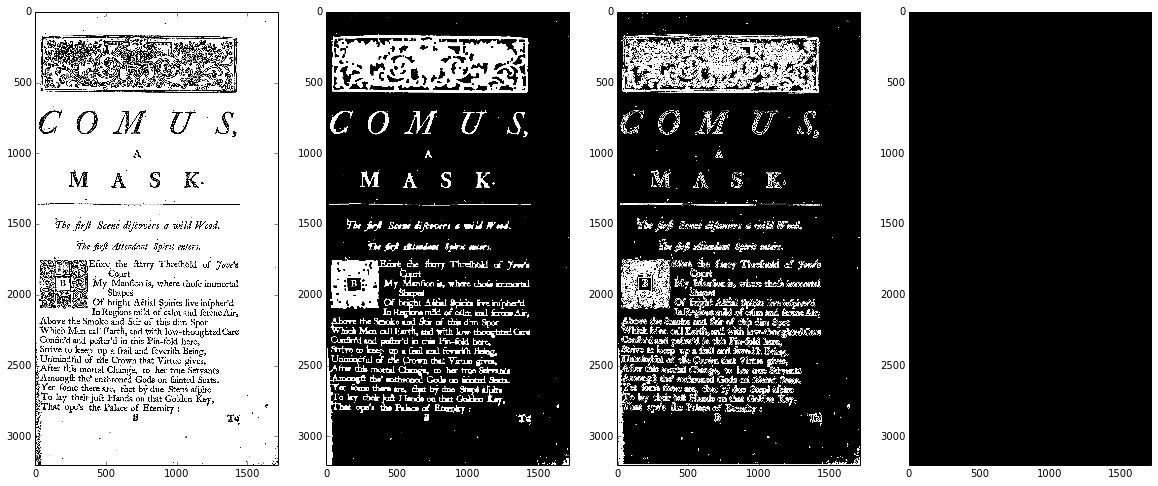

In [8]:
tim = imgs[8]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
_,thresh = cv2.threshold(tim,150,255,cv2.THRESH_BINARY_INV)
opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
contours, hierarchy = cv2.findContours(tim.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
print hierarchy
tc = np.zeros(tim.shape)
tc2 = np.zeros(tim.shape)
for c in contours:
    [x,y,w,h] = cv2.boundingRect(c)
    a = cv2.contourArea(c)
    a = w*h
    if True or a < 10000:
        cv2.drawContours(tc, c, -1, (255,255,255), 3)
    else:
        cv2.drawContours(tc2, c, -1, (255,255,255), 3)

cv2.imwrite(sample_dir+'/test.png',tc)
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,10)
ax[0].imshow(tim,cmap=cm.Greys_r)
ax[1].imshow(opening,cmap=cm.Greys_r)
ax[2].imshow(tc,cmap=cm.Greys_r)
ax[3].imshow(tc2,cmap=cm.Greys_r)

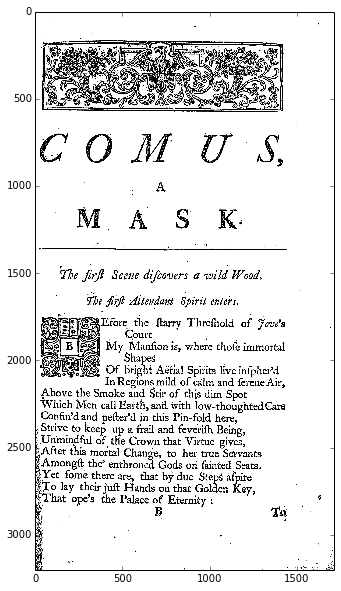

In [43]:
tim = imgs[8]
#tim = cv2.imread("/Users/dgorissen/blobtest.jpg", cv2.IMREAD_GRAYSCALE)

params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 1
# Filter by Area.
#params.filterByArea = True
#params.minArea = 1500
# Filter by Circularity
#params.filterByCircularity = True
#params.minCircularity = 0.1
# Filter by Convexity
#params.filterByConvexity = True
#params.minConvexity = 0.87
# Filter by Inertia
#params.filterByInertia = True
#params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector(params)
 
# Detect blobs.
keypoints = detector.detect(tim)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(tim, keypoints, np.array([]), (0,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
plt.imshow(im_with_keypoints, cmap=cm.Reds)

* image  1
* image  4
* image  8
* image  16
* image  17


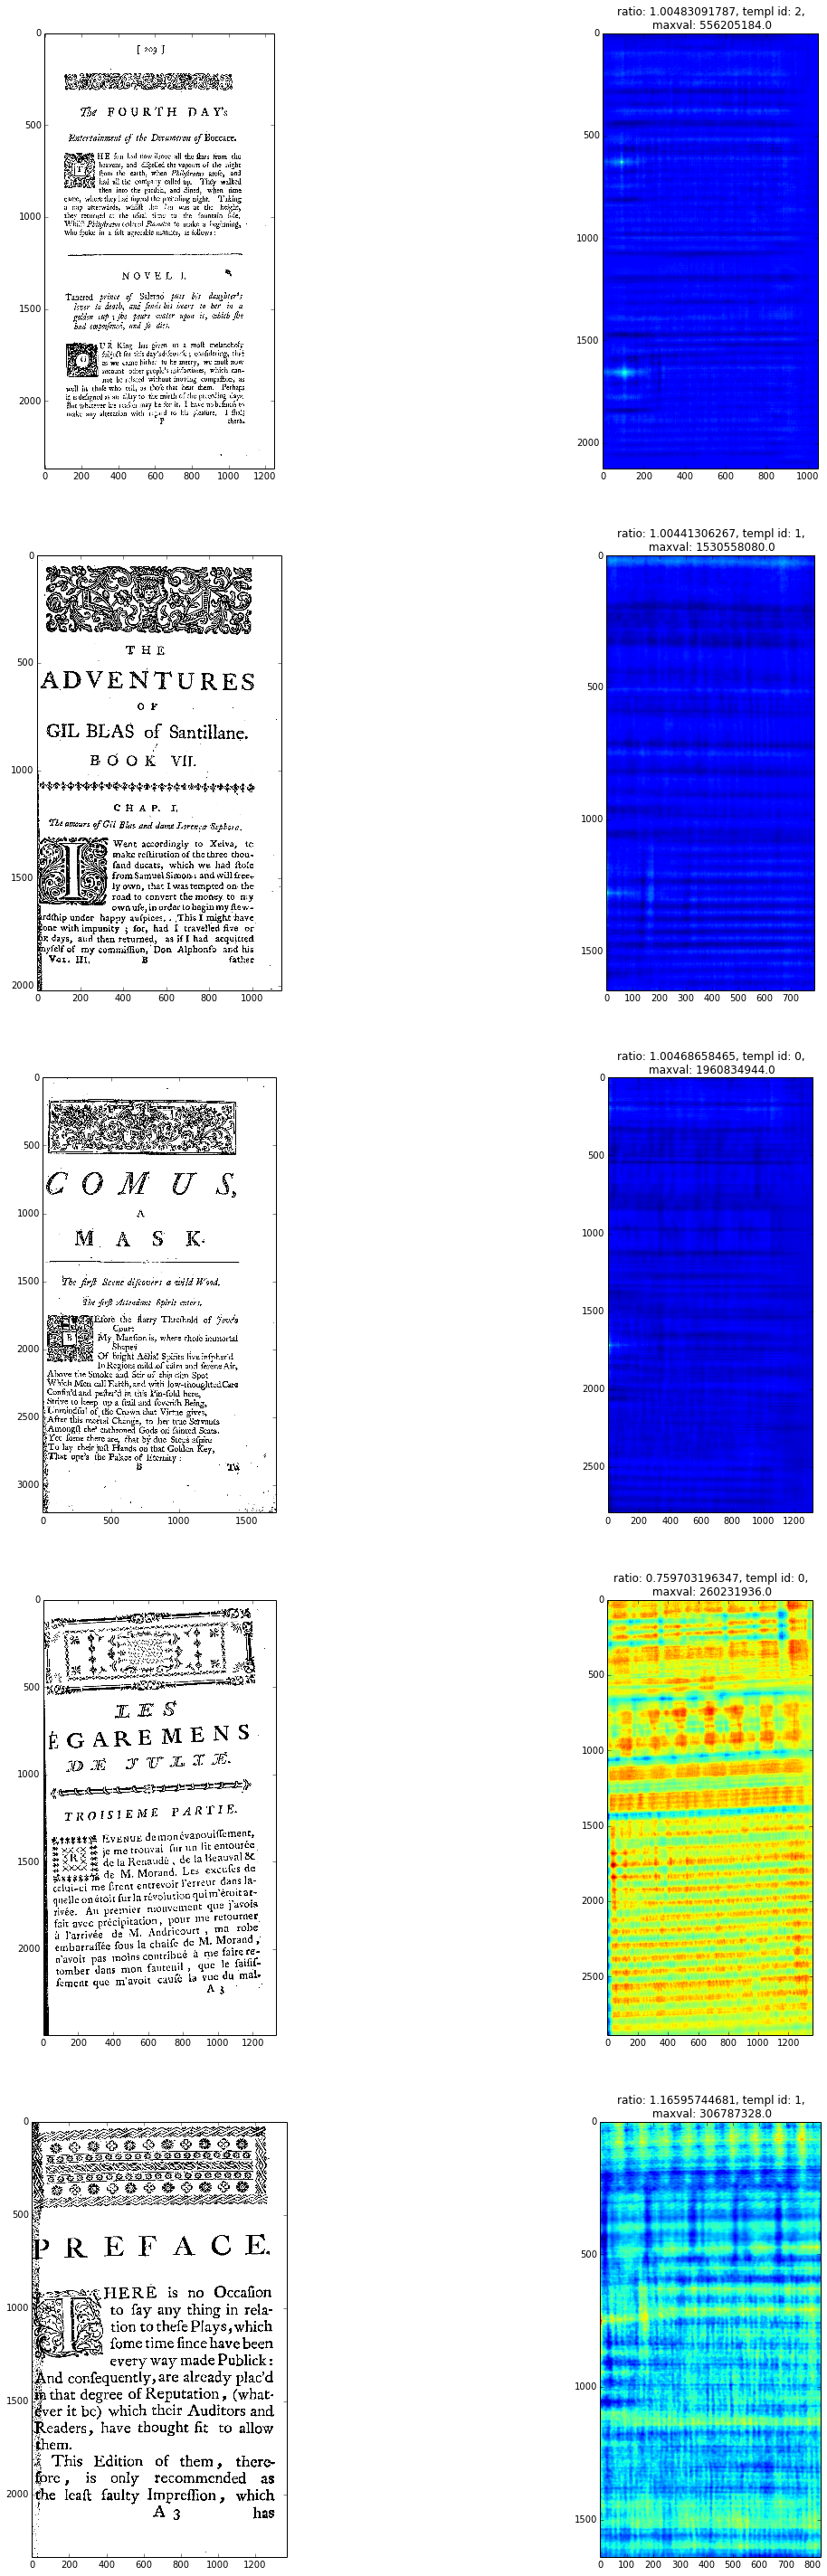

In [75]:
# multi scale template matching
def match_template(ims, threshold=0.7):
    fig, ax = plt.subplots(len(ims),2)
    fig.set_size_inches(20,10*len(ims))
    
    for idx, i in enumerate(ims):
        print "* image ", i
        im = imgs[i]
        im_copy = im.copy()

        ax[idx, 0].imshow(im,cmap=cm.Greys_r)
        
        found = None
 
        # loop over the scales of the image
        scales = np.linspace(0.4, 1.5, 25)[::-1]
        for sidx, scale in enumerate(scales):
            # resize the image according to the scale, and keep track
            # of the ratio of the resizing
            resized = imutils.resize(im, width = int(im.shape[1] * scale))
            ratio = im.shape[1] / float(resized.shape[1])
 
            #print "  * scale: ", scale
            for tidx, template in enumerate(templates):
                w, h = template.shape[::-1]
                res = cv2.matchTemplate(resized,template,cv2.TM_CCOEFF_NORMED)

                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                #print "    maxval: %s, maxloc: %s" % (max_val, max_loc)

                # if we have found a new maximum correlation value, then ipdate
                # the bookkeeping variable
                if found is None or max_val > found[0]:
                    found = (max_val, max_loc, res, ratio, tidx)
            
        #loc = np.where( res >= threshold)
        #for pt in zip(*loc[::-1]):
        #    cv2.rectangle(im_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

        (max_val, max_loc, res, ratio, tidx) = found
        ax[idx, 1].imshow(res)
        ax[idx, 1].set_title("ratio: %s, templ id: %s,\n maxval: %s" % (ratio, tidx, max_val))

        #ax[idx, 1].imshow(tim_copy)

ims = [1, 4, 8, 16, 17]
match_template(ims)

In [76]:
vis = tim.copy()
mser = cv2.MSER_create()
regions = mser.detectRegions(tim, None)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
io.imshow(vis)

AttributeError: 'module' object has no attribute 'MSER_create'

In [ ]:
L = measure.label(im)
plt.figure(figsize=(10,10))
io.imshow(L)
unique, counts = np.unique(L, return_counts=True)
comps = np.asarray((unique, counts)).T

In [ ]:
fn = sample_dir+"/"+files[0]
print fn
print pytesseract.image_to_string(Image.open(fn))
plt.figure(figsize=(10,10))
io.imshow(imgs[0])